In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
plt.rcParams.update({'font.size': 10})

In [2]:
#load data
df = pd.read_csv('data.csv')

In [3]:
outcome = 'delta_rating' # also recall@10 and ndcg@10
predictors = ['Rock', 'Rap', 'World', 'Metal', 'Electronic', 'Classical','genre_entropy','Canada','UK', 'US','France','country_entropy','country_none']
#user characteristics ['gs_score', 'mean_age_songs','age', 'median_rank','active_eng']
n_bootstrap = 1000
scaler = MinMaxScaler()

In [4]:
results = []

for model in df.model.unique():
    temp = df[df.model == model].dropna().copy()
    temp[predictors] = scaler.fit_transform(temp[predictors])

    for predictor in tqdm(predictors):
        coefs = []

        for _ in range(n_bootstrap):
            sample = resample(temp)
            x_sample = sample[predictor].values.reshape(-1, 1)
            y_sample = sample[outcome].values
            reg = LinearRegression().fit(x_sample, y_sample)
            # Get index of current predictor
            coef = reg.coef_[0]
            coefs.append(coef)

        coefs = np.array(coefs)
        mean_coef = np.mean(coefs)
        ci_lower = np.percentile(coefs, 2.5)
        ci_upper = np.percentile(coefs, 97.5)

        results.append({
            'model': model,
            'predictor': predictor,
            'mean': mean_coef,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })

# Convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:35<00:00,  2.75s/it]


In [5]:
results_df['plot_model'] = 'llama'
results_df.loc[results_df.model == 'deepseek-r1', 'plot_model'] = 'deepseek'
results_df.loc[results_df.model == 'gemini-2.0-flash', 'plot_model'] = 'gemini'

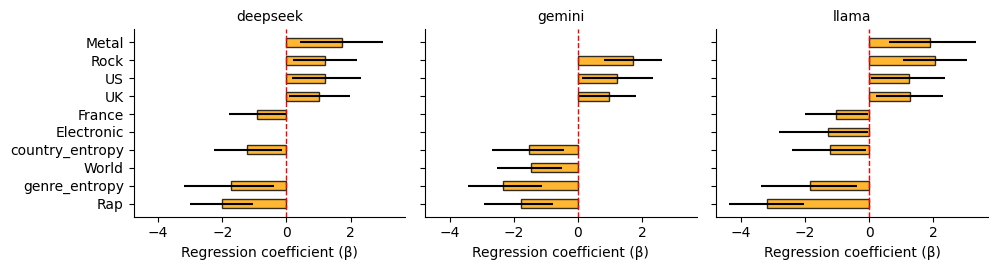

In [6]:
results_df['to_plot'] = results_df['ci_lower'] * results_df['ci_upper']
results_df['ci_width'] = results_df['ci_upper'] - results_df['ci_lower']

plot_df = results_df[(results_df['to_plot'] > 0)&(results_df.ci_width < 10)].copy()

# Ensure all predictors appear in every plot_model
all_predictors = plot_df['predictor'].unique()
all_models = plot_df['plot_model'].unique()

# Pad missing predictors with NaNs
padded = []
for model in all_models:
    model_df = plot_df[plot_df['plot_model'] == model]
    missing_preds = set(all_predictors) - set(model_df['predictor'])

    # Add existing rows as dicts
    padded.extend(model_df.to_dict(orient='records'))

    # Add missing rows
    for pred in missing_preds:
        padded.append({
            'plot_model': model,
            'predictor': pred,
            'mean': np.nan,
            'ci_lower': np.nan,
            'ci_upper': np.nan
        })

plot_df = pd.DataFrame(padded)

predictor_means = (
    plot_df.groupby('predictor')['mean']
    .mean()
    .sort_values()
    .reset_index()
)

# Assign global order
predictor_order = {p: i for i, p in enumerate(predictor_means['predictor'])}
plot_df['predictor_ordered'] = plot_df['predictor'].map(predictor_order)

g = sns.FacetGrid(
    data=plot_df,
    col='plot_model',
    sharex=True,
    sharey=True,
    height=2.8,
    aspect=1.2
)

def plot_bars_with_ci(data, color, **kwargs):
    # Sort inside the plotting function to preserve order per facet
    data = data.sort_values('predictor_ordered')
    y_positions = range(len(data))
    plt.barh(
        y=y_positions,
        width=data['mean'],
        xerr=[data['mean'] - data['ci_lower'], data['ci_upper'] - data['mean']],
        color=color,
        edgecolor='black',
        height=0.5,
        alpha=0.8
    )
    plt.yticks(y_positions, data['predictor'])

g.map_dataframe(plot_bars_with_ci, color='orange')

# Add vertical line at zero
for ax in g.axes.flat:
    ax.axvline(0, color='red', linestyle='--', linewidth=1)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Regression coefficient (β)")

plt.tight_layout()
plt.show()

In [7]:
#load the doubly robust results
ate = pd.read_csv('dobly_robust.csv')

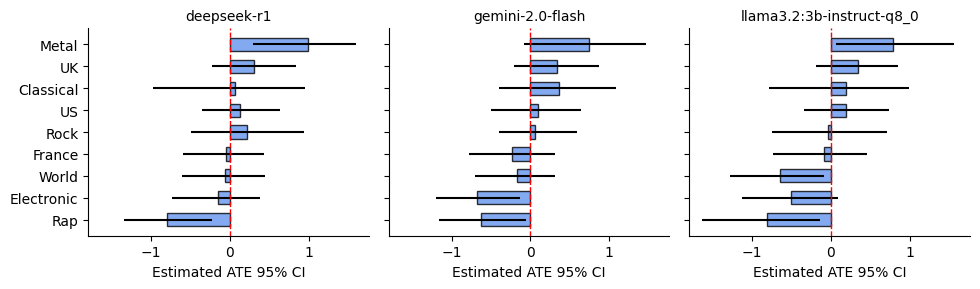

In [9]:
predictor_means = (
    ate.groupby('treat')['mean']
    .mean()
    .sort_values()
    .reset_index()
)

# Assign global order
predictor_order = {p: i for i, p in enumerate(predictor_means['treat'])}
ate['predictor_ordered'] = ate['treat'].map(predictor_order)

g = sns.FacetGrid(
    data=ate,
    col='model',
    sharex=True,
    sharey=True,
    height=3,
    aspect=1.1
)

def plot_bars_with_ci(data, color, **kwargs):
    # Sort inside the plotting function to preserve order per facet
    data = data.sort_values('predictor_ordered')
    y_positions = range(len(data))
    plt.barh(
        y=y_positions,
        width=data['mean'],
        xerr=[data['mean'] - data['ci_lower'], data['ci_upper'] - data['mean']],
        color=color,
        edgecolor='black',
        height=0.6,
        alpha=0.8
    )
    plt.yticks(y_positions, data['treat'])

g.map_dataframe(plot_bars_with_ci, color='cornflowerblue')

# Add vertical line at zero
for ax in g.axes.flat:
    ax.axvline(0, color='red', linestyle='--', linewidth=1)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Estimated ATE 95% CI")

plt.tight_layout()
plt.show()